<div style="display:block">
    <div style="width: 20%; display: inline-block; text-align: left;">
    </div>
    <div style="width: 59%; display: inline-block">
        <h1  style="text-align: center">Back Propagation Neural Network</h1>
        <div style="width: 85%; text-align: center; display: inline-block;"><i>Authors:</i> <strong>Manoj Kumar Das </strong> </div>
    </div>
    <div style="width: 20%; text-align: right; display: inline-block;">
        <div style="width: 100%; text-align: left; display: inline-block;">
            <i>Created: </i>
            <time datetime="2014-03-10" pubdate>March 10, 2016</time>
        </div>
        <div style="width: 100%; text-align: left; display: inline-block;">
            <i>Modified: </i>
            <time datetime="2014-03-12" pubdate>January 3, 2018</time>
        </div>
    </div>
</div>

## Introduction

In this notebook, we attempt to write a python code to replicate a back propagation neural network and have it trained to perform as a classifier over the MNIST data (images of digits from 0 to 9). The objective of this assignment is to have a highly flexible, generic and functional(oh yeah!!!) code so as to experiment the performance of the network having the possibility to change any of the architectural parameters like the number of hidden layers and the number of neurons in them, activation function of choice in each layer. Basic equations used to write the code are presented, without a complete an in-depth explanation the functioning of back propagation neural network and the gradient descent algorithm. Comment section within the code expaliin the codes in detail. 

We have 60,000 samples of training data containing images of digits from 0 to 9. The neural network will be trained over all the 60,000 samples for a fixed number of epochs and again will be made to predict over 10,000 samples of a validation set to set to which class they belong to.

## Details of Neural Network:
In this assignment, we have chosen to test a network with only one hidden layer. In this notebook we attempt the classic gradient descent algorithm and not Stochastic Gradient Descent algorithm. For this reason the number of neurons in the input layer is equal to the number of pixels we have coming from the image, and 10 output neurons, coming from the output layer corresponding to the 10 classes. In the training set the desired output of each neuron will be set to zeros except for the class the image belongs to which will set to one. On validation of the network's prediction, we consider the class corresponding to the neuron which gives out the maximum value.
The number of neurons in the hidden layer is chosen to be 149, this is obtained by taking the average(closest integer) number of non-zero pixels over all the 60,000 samples of the training dataset.
Equations for the forward pass and reverse pass are as below, [1] from refrences can be used to have in-depth understading on how we arrive to the equations. 

$z_{in_{j}}~=~\sum{x_{i}  \textit{v}_{i,j}}$

$z_{j}~=~f(z_{in_{j}})$,  activation function of the hidden layer

$y_{in_{k}}~=~\sum{z_{j}  w_{j,k}}$

$\Delta{w_{j,k}}~=~\alpha\delta_{k}\textit{z}_{j}$ where $\delta_{k}~=~(y_{dk}-y_{k})~f^{'}(y_{in_{k}})$

$\Delta{v_{i,j}}~=~\alpha\delta_{j}x_{j}$ where $\delta_{j}~=~\delta_{in_{j}}~f^{'}(z_{in_{j}})$ and $\delta_{in_{j}}~=~\sum{\delta_{k}w_{j,k}}$

$E~=~\frac{1}{2}\sum{(y_{dk}-y_{k})^{2}}$, sum square error

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()">
<input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
import sys 
import struct
import msgpack
import cPickle
import bigfloat 
import numpy as np
from array import array
# from cvxopt.base import matrix
from scipy.special import expit
import matplotlib.pyplot as plt
%matplotlib inline

## Loading Data

trainImages are the images used for training and train Labels are their corresponding labels. Similarly testImages and testLables are what will be used for the validation. Each image is a 28 x 28 pixel grayscale image, which has been made availabel a single vector of 1 x 784. We attempt to re-arrange the image data and didvide it by 255 to get an equivalent of convert the rnage of each pixel value between 0 and 1. We also convert the labels to a one hot rod conversion format, which means if the label correponding to an image of the digit "0" will be represented as [1,0,0,0,0,0,0,0,0,0] and similarly for digit "1" it will be [0,1,0,0,0,0,0,0,0,0] and so on. 

In [4]:
labelsFile = open('train-labels.idx1-ubyte', 'rb')
magic_nr, size = struct.unpack(">II", labelsFile.read(8))
trainLabels = map(lambda x: np.eye(10)[x].reshape(1,-1), array("b", labelsFile.read())) 
labelsFile.close()

imagesFile = open('train-images.idx3-ubyte', 'rb')
magic_nr, size, rows, cols = struct.unpack(">IIII", imagesFile.read(16))
trainImages = np.vectorize(lambda x: float(x *1.0 / 255 ))(array("B", imagesFile.read())).reshape(-1, rows * cols)
trainImages = np.array(map(lambda x: x.reshape(1,-1), trainImages))
trainLabels = np.array(map(lambda x: np.array(x).reshape(1,-1), trainLabels))
imagesFile.close()

labelsFile = open('t10k-labels.idx1-ubyte', 'rb')
magic_nr, size = struct.unpack(">II", labelsFile.read(8))
testLabels = map(lambda x: np.eye(10)[x].reshape(1,-1), array("b", labelsFile.read())) 
labelsFile.close()

imagesFile = open('t10k-images.idx3-ubyte', 'rb')
magic_nr, size, rows, cols = struct.unpack(">IIII", imagesFile.read(16))
testImages = np.vectorize(lambda x: float(x *1.0 / 255 ))(array("B", imagesFile.read())).reshape(-1, rows * cols)
testImages = np.array(map(lambda x: x.reshape(1,-1), testImages))
testLabels = np.array(map(lambda x: np.array(x).reshape(1,-1), testLabels))
imagesFile.close()

### Images and Labels
Below we plot a few images of the training set. The title above each image is taken from the corresponding labels that we have from the training set to show you how they co-incincide.

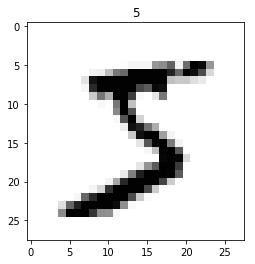

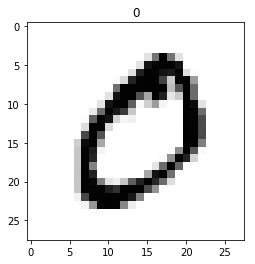

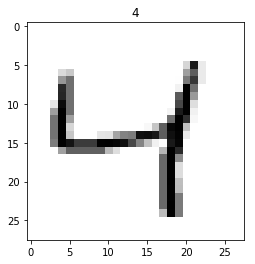

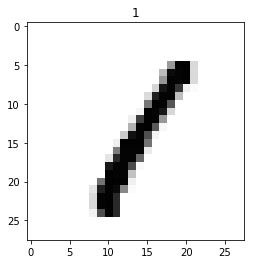

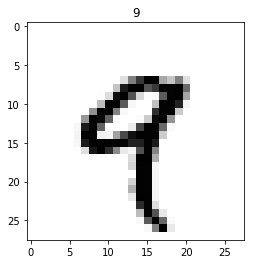

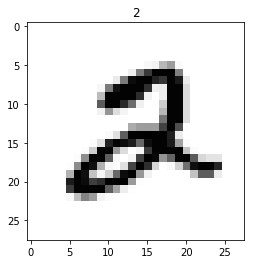

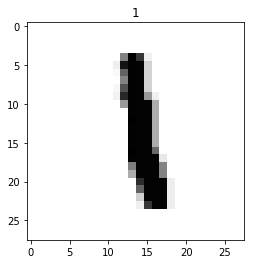

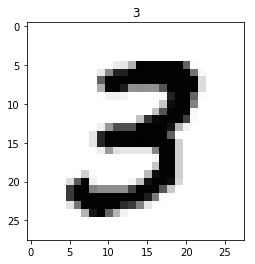

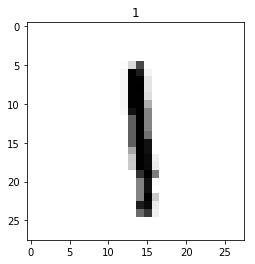

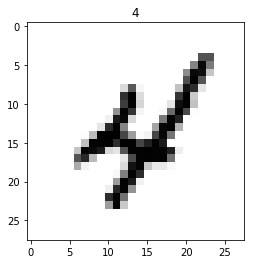

In [5]:
for x in xrange(10):
    plt.imshow(trainImages[x,:,:].reshape(28, 28), 
               cmap='Greys', interpolation='nearest')
    plt.title(np.nonzero(trainLabels[x,:,:])[1][0])
    plt.pause(0.1)

## Main Code

Below is the main code block for the back propagation, the redMap function does the forward pass, and backRedMap function performs the reverse pass which updates the weights. The activation functions and their corresponding derivatives are defined which will be used by the two mentioned functions respectively. The function fronAndBackPass runs over the former two functions for a given sample and evaluates the loss value for the new updated weights. The function gradientDescent repeats frontAndBackPass every sample.The final line in below code block repeats the gradientDescent function according to the number of epochs is specified.

In [7]:
def mySoftmax(values):
    e = np.vectorize(lambda x: bigfloat.exp(x))(values)
    return np.vectorize(lambda x: float(x))(e / np.sum(e))
    
def redMap(redMapSeqFunc, redMapSeq):
    redmapResult = [redMapSeqFunc[0](redMapSeq[0], redMapSeq[1])]
    map(lambda x, y: redmapResult.append(x(redmapResult[-1], y)), redMapSeqFunc[1:], redMapSeq[2:]);
    return redmapResult

def backRedMap(backRedMapSeqFunc, backRedMapSeq, inPut, tarGet, w, alpha):
    ro = [(tarGet-backRedMapSeq[-1]) * backRedMapSeqFunc[0](backRedMapSeq[-1])]
    map(lambda x, y, z: ro.insert(0, np.dot(ro[0], x.T) * y(z)), reversed(w[1:]), backRedMapSeqFunc[1:],
        reversed(backRedMapSeq[:-1]));
    backRedMapResult = map(lambda x, y: alpha * np.dot(x.T,y), [inPut] + backRedMapSeq[:-1], ro)
    return backRedMapResult
    
def frontAndBackPass(inPut, tarGet):
    global w, actFuncs, actDeriveFuncs, sumSquareError, alpha, regLambdaDiff    
    w = map(lambda x,y: (regLambdaDiff * x) + y, w, 
            backRedMap(actDeriveFuncs,
            redMap(actFuncs, [inPut] + w), inPut, tarGet, w, alpha));
    sumSquareError.extend([np.sum((tarGet - redMap(actFuncs, [inPut] + w)[-1]) ** 2) * 1.0 / 2])

def gradientDescent(epoch):
    global inSamples, outSamples
    map(lambda x, y: frontAndBackPass(x, y), inSamples, outSamples)
    sys.stdout.write('\r')
    sys.stdout.write("[%s] %s%d" % ('='*(epoch + 1), 'epochs: ', epoch + 1))
    sys.stdout.flush()
    
sigmoid = lambda x, y: expit(np.dot(x, y))
tanh = lambda x, y: np.tanh(np.dot(x, y))
relu = lambda x, y: np.maximum(0,np.dot(x, y))
softmax = lambda x, y: mySoftmax(np.dot(x, y))

sigmoidDerive = np.vectorize(lambda x: x * (1-x))
tanhDerive = np.vectorize(lambda x: 1 - (x ** 2)) 
reluDerive = np.vectorize(lambda x: int(x > 0))
softmaxDerive = np.vectorize(lambda x: x * (1-x))

## Small Demonstration

Now we are going to just perform a training with 1000 epochs for only the first 10 samples and view how the gradient descent algorithm updates the weights of the network as we back propagate across the neural network.

In [8]:
samples = 10 #Chossing only first 10 samples
'''Setting the number of neuron of the hidden layer to the average number of non-zero pixels across all samples'''
hiddenSpecs = np.sum(map(lambda x: len(x[x>0]), trainImages))/trainImages.shape[0]  
actSpecs = ['relu', 'softmax'] #Chosen activation functions
alpha = 1e-01
regLambda = 0 #Not going for any regulation
epochs = 1000

inSamples = trainImages[:samples]
outSamples = trainLabels[:samples]
sumSquareError = []
regLambdaDiff = 1 - regLambda
actFuncs = eval(str(actSpecs).translate(None,"'"))
actDeriveFuncs = eval(str(map(lambda x: x + 'Derive', reversed(actSpecs))).translate(None,"'"))

'''Create a list for number of nodes for every hidden layer. The number of values in the list 
determines the number of hidden layers and the value itself correpsonds to the number of nodes respectively 
for each hidden layer. Specifying the needed activation function for every layer''' 
netArch = np.hstack((inSamples.shape[2],hiddenSpecs, outSamples.shape[2]))

#Random intial weight generation
w = map(lambda x, y: 0.001 * np.random.rand(x, y), netArch[:-1], netArch[1:])

#Training execution
map(lambda x: gradientDescent(x), np.arange(epochs));

[=======================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

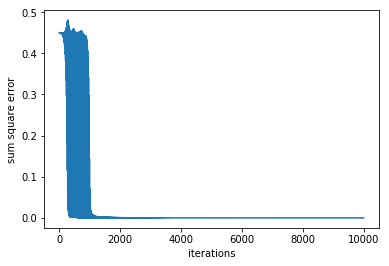

In [9]:
plt.plot(sumSquareError)
plt.xlabel('iterations')
plt.ylabel('sum square error')
plt.show()

In [10]:
print "Predicted labels again true labels of the validation set for the first few images in the training set"
for index in xrange(10) :
    print np.argmax(redMap(actFuncs, [inSamples[index]] + w)[-1]),
    print np.argmax(outSamples[index])

Predicted labels again true labels of the validation set for the first few images in the training set
5 5
0 0
4 4
1 1
9 9
2 2
1 1
3 3
1 1
4 4


## Full experiment results

We have trained the above network for 500 epochs over all the 60,000 samples. No regulation was set and the learning rate, $\alpha$  was set to 0.01. The weights are then saved, which we shall now utilize and test and see how the network performs over the validation dataset.

In [11]:
#importing  the weights of the trained network
w = cPickle.load(open('weightFile.p', 'rb')) 

'''Genrating compare array which conatins two colums, the first column is the predicted class for every sample and
the second column the actual class the sample belongs to'''
compare = np.array(map(lambda index: [np.argmax(redMap(actFuncs, [testImages[index]] + w)[-1]),
                                  np.argmax(testLabels[index])], np.arange(testLabels.shape[0])))

'''Computing the accuracy, this is done by subtracting the two columns of the above array, if the prediction is 
incorrect you get a non-zero value, therefore by couting the number non-zero values you get the number of wrong
predictions'''
accuracy = (testLabels.shape[0] - np.nonzero(compare[:,0]-compare[:,1])[0].shape[0]) * 100.0 / testLabels.shape[0]

print 'number of incorrect predictions = ' + str(np.nonzero(compare[:,0] - compare[:,1])[0].shape[0])
print 'accuracy = ' + str(accuracy) + '%'

number of incorrect predictions = 247
accuracy = 97.53%


## Conclusion

There can be improvements done on this experiment by varying the learning rate and going for regulation. This code also enables us to go for a second layer or as many layers desired. The leaky Relu and markout activation function are yet to be implemented. Moreover, softmax activation can be replaced with sigmoid to get a similar result and decrease computation time. This assignment hopefully shows how the neural network less or more performs but there is much that can be done and should be experimented to improve the performance.